In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration & Hyperparameters ---
LATENT_DIM = 64      # Latent dimension
BATCH_SIZE = 256     # Batch size for training
EPOCHS = 30          # Number of training epochs (can be increased for better performance)
LR = 0.0002          # Learning rate for optimizers
BETA1 = 0.5          # Adam optimizer beta1
LAMBDA_RECON = 10    # Weight for the reconstruction loss

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- Load the Datasets for CBIGan ---
X_train_df = pd.read_parquet('processed_data/cbigan_X_train.parquet')
y_train_df = pd.read_parquet('processed_data/cbigan_y_train.parquet')
X_test_df = pd.read_parquet('processed_data/cbigan_X_test.parquet')
y_test_df = pd.read_parquet('processed_data/cbigan_y_test.parquet')

INPUT_DIM = X_train_df.shape[1]
LABEL_DIM = 1 # The label is a single digit (0 or 1)

# --- PyTorch Dataset and DataLoader for CBIGan ---
class ConditionalDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets and dataloaders
train_dataset = ConditionalDataset(X_train_df, y_train_df['label'])
test_dataset = ConditionalDataset(X_test_df, y_test_df['label'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaded successfully.")
print(f"Input Dimension: {INPUT_DIM}")
print(f"Training data shape: {X_train_df.shape}")
print(f"Testing data shape: {X_test_df.shape}")

Data loaded successfully.
Input Dimension: 190
Training data shape: (96822, 190)
Testing data shape: (49971, 190)


In [3]:
# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, latent_dim)
        )
    def forward(self, x):
        return self.model(x)

# --- Generator (Decoder) ---
class Generator(nn.Module):
    def __init__(self, latent_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_dim),
            nn.Sigmoid() # Because input data is scaled to [0, 1]
        )
    def forward(self, z, c):
        zc = torch.cat([z, c], dim=1)
        return self.model(zc)

# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, input_dim, latent_dim, label_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + latent_dim + label_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, z, c):
        x_z_c = torch.cat([x, z, c], dim=1)
        return self.model(x_z_c)

print("CBIGan model architectures defined.")

CBIGan model architectures defined.


In [4]:
# --- Instantiate models and move to device ---
encoder = Encoder(INPUT_DIM, LATENT_DIM).to(device)
generator = Generator(LATENT_DIM, LABEL_DIM, INPUT_DIM).to(device)
discriminator = Discriminator(INPUT_DIM, LATENT_DIM, LABEL_DIM).to(device)

# --- Loss Functions ---
adversarial_loss = nn.BCELoss().to(device)
reconstruction_loss = nn.L1Loss().to(device) # L1 is robust for reconstruction

# --- Optimizers ---
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_ge = optim.Adam(list(generator.parameters()) + list(encoder.parameters()), lr=LR, betas=(BETA1, 0.999))

print("Models, losses, and optimizers have been initialized.")

Models, losses, and optimizers have been initialized.


In [5]:
# --- Training Loop ---
g_losses = []
d_losses = []

print("Starting CBIGan training...")
for epoch in range(EPOCHS):
    loop = tqdm(train_loader, leave=True)
    total_g_loss = 0.0
    total_d_loss = 0.0

    for i, (real_x, labels) in enumerate(loop):
        real_x = real_x.to(device)
        labels = labels.to(device)
        
        # Adversarial ground truths
        valid = torch.ones(real_x.size(0), 1, device=device)
        fake = torch.zeros(real_x.size(0), 1, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_d.zero_grad()
        
        # On real data pairs (x, E(x))
        z_real = encoder(real_x).detach()
        d_real_pred = discriminator(real_x, z_real, labels)
        d_real_loss = adversarial_loss(d_real_pred, valid)

        # On fake data pairs (G(z), z)
        z_fake = torch.randn(real_x.size(0), LATENT_DIM, device=device)
        fake_x = generator(z_fake, labels).detach()
        d_fake_pred = discriminator(fake_x, z_fake, labels)
        d_fake_loss = adversarial_loss(d_fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_d.step()

        # -------------------------
        #  Train Generator-Encoder
        # -------------------------
        optimizer_ge.zero_grad()
        
        # 1. Adversarial Loss (Generator fools Discriminator)
        z_fake_for_g = torch.randn(real_x.size(0), LATENT_DIM, device=device)
        gen_x = generator(z_fake_for_g, labels)
        d_pred_for_g = discriminator(gen_x, z_fake_for_g, labels)
        g_adv_loss = adversarial_loss(d_pred_for_g, valid)
        
        # 2. Reconstruction Loss (x -> E(x) -> G(E(x), c) -> x')
        z_real_for_g = encoder(real_x)
        recon_x = generator(z_real_for_g, labels)
        g_recon_loss = reconstruction_loss(recon_x, real_x)
        
        # Total G-E Loss
        ge_loss = g_adv_loss + LAMBDA_RECON * g_recon_loss
        ge_loss.backward()
        optimizer_ge.step()
        
        # --- Logging ---
        total_g_loss += ge_loss.item()
        total_d_loss += d_loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(g_loss=ge_loss.item(), d_loss=d_loss.item())
        
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

print("\n--- Model Training Complete ---")

Starting CBIGan training...


Epoch [30/30]: 100%|██████████| 379/379 [00:16<00:00, 23.55it/s, d_loss=7.62e-7, g_loss=14.7]


--- Model Training Complete ---


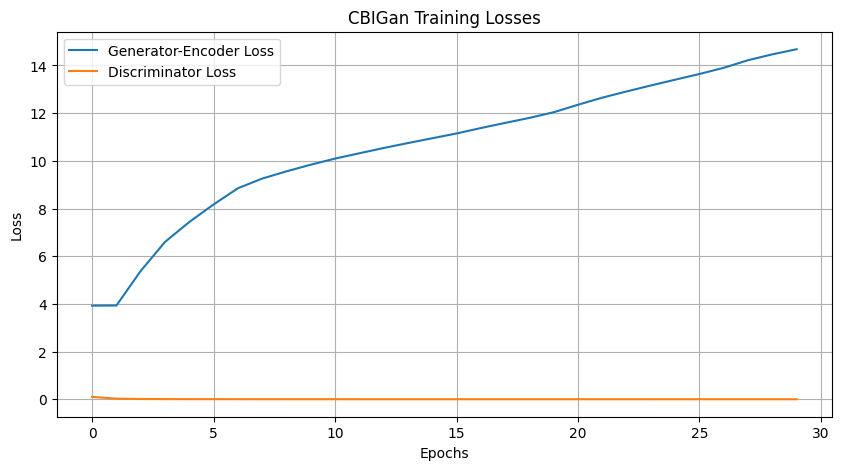

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator-Encoder Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('CBIGan Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print("Evaluating Model and Calculating Anomaly Scores...")

# Set models to evaluation mode
encoder.eval()
generator.eval()
discriminator.eval()

anomaly_scores = []
all_true_labels = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Anomaly score based on conditioned reconstruction error
        z_encoded = encoder(batch_x)
        x_reconstructed = generator(z_encoded, batch_y)
        
        # Calculate L1 loss (MAE) for each sample in the batch
        errors = torch.mean(torch.abs(batch_x - x_reconstructed), dim=1)
        
        anomaly_scores.extend(errors.cpu().numpy())
        all_true_labels.extend(batch_y.cpu().numpy().flatten())

anomaly_scores = np.array(anomaly_scores)
all_true_labels = np.array(all_true_labels)

# Normalize scores to [0, 1] for easier thresholding and comparison
anomaly_scores_normalized = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

print("Evaluation complete.")

Evaluating Model and Calculating Anomaly Scores...
Evaluation complete.


Area under ROC curve (AUC-ROC): 0.5704
Optimal threshold found via Youden's J statistic: 0.2778

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.67      0.80      0.73     31610
  Attack (1)       0.48      0.32      0.39     18361

    accuracy                           0.62     49971
   macro avg       0.58      0.56      0.56     49971
weighted avg       0.60      0.62      0.60     49971



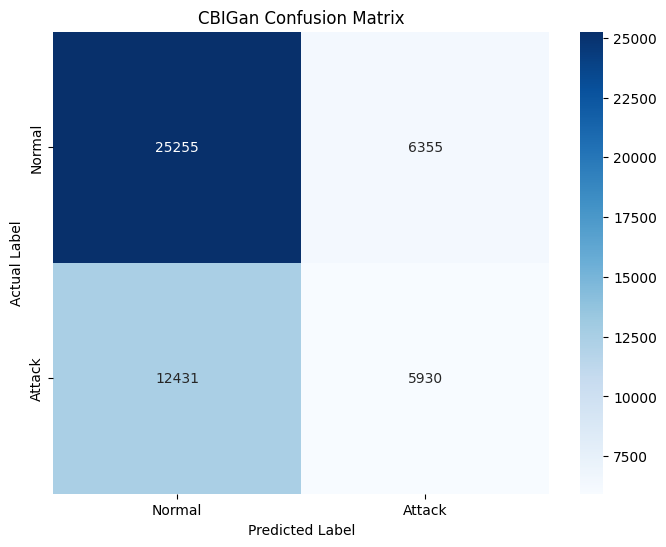

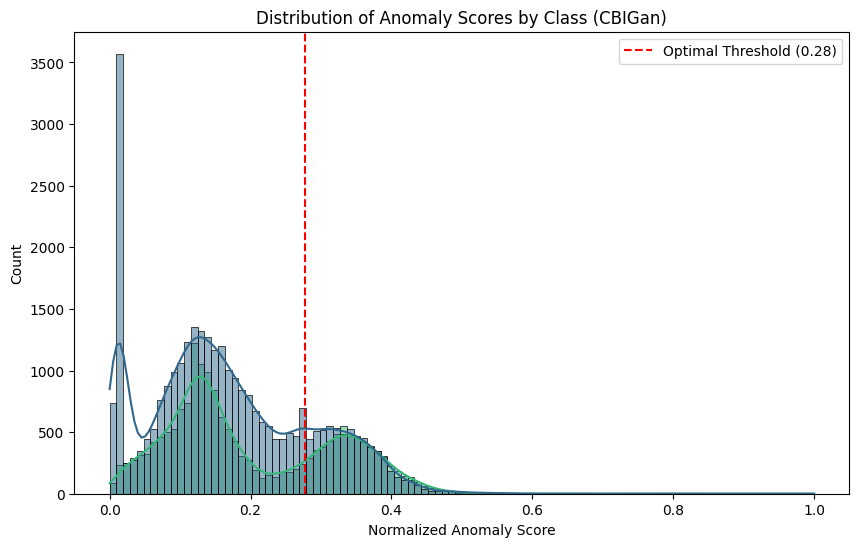

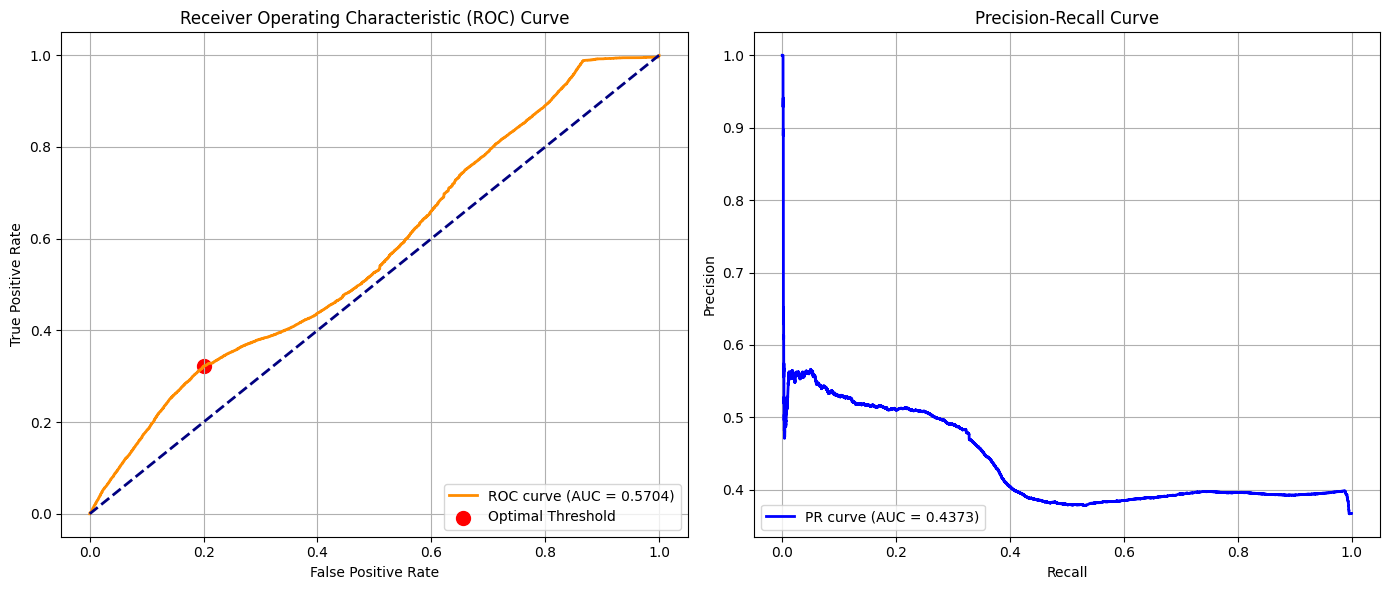

Area under ROC curve (AUC-ROC): 0.5704
Optimal threshold found via Youden's J statistic: 0.2778

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.67      0.80      0.73     31610
  Attack (1)       0.48      0.32      0.39     18361

    accuracy                           0.62     49971
   macro avg       0.58      0.56      0.56     49971
weighted avg       0.60      0.62      0.60     49971



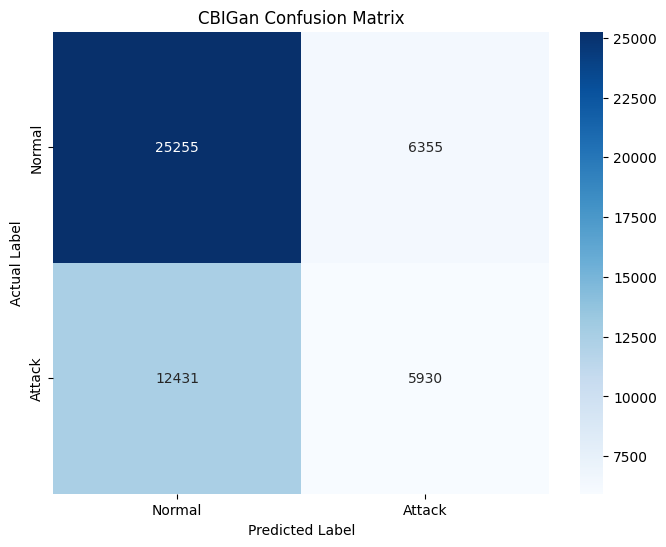

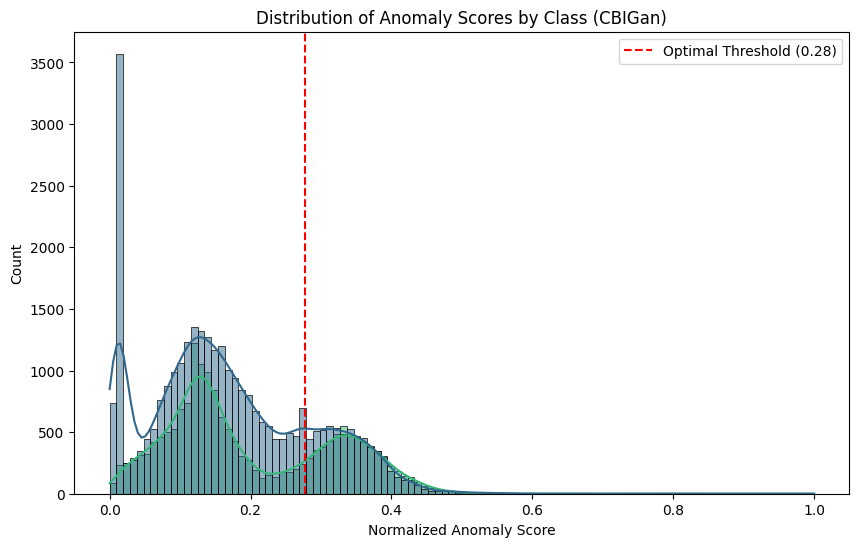

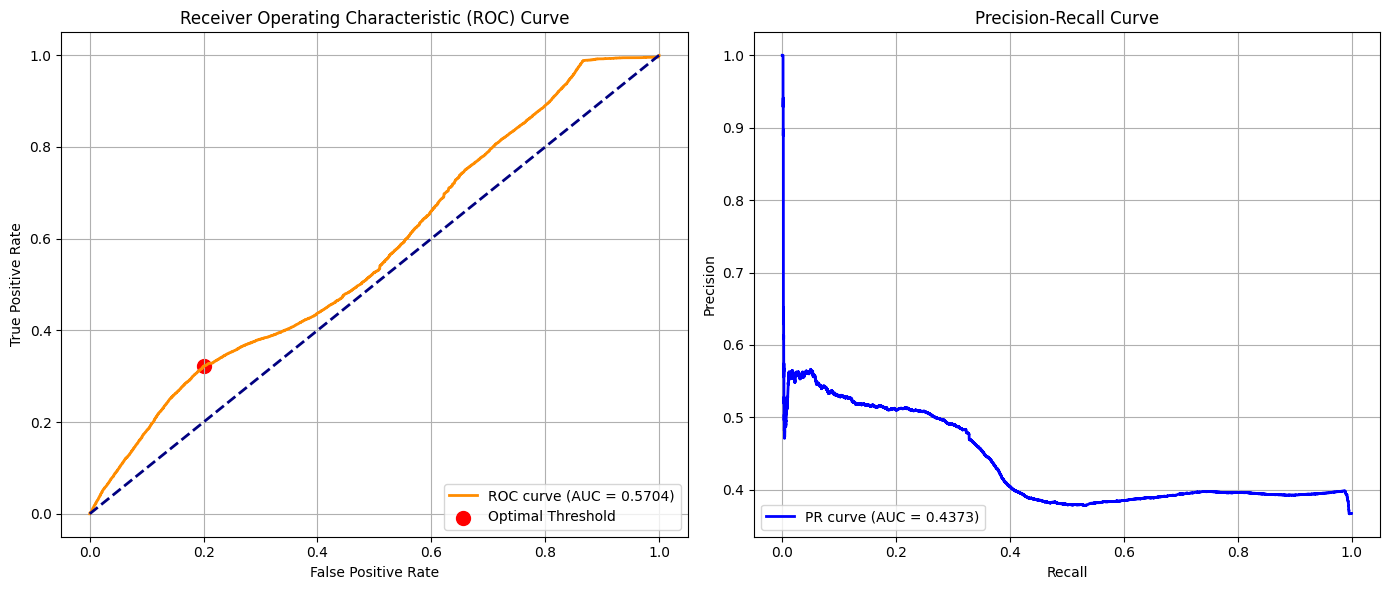

In [8]:
# --- Find Optimal Threshold using ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_true_labels, anomaly_scores_normalized)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Area under ROC curve (AUC-ROC): {roc_auc:.4f}")
print(f"Optimal threshold found via Youden's J statistic: {optimal_threshold:.4f}")

# --- Evaluate using the optimal threshold ---
y_pred = (anomaly_scores_normalized >= optimal_threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(all_true_labels, y_pred, target_names=['Normal (0)', 'Attack (1)']))

# --- Create Plots for Report ---

# Confusion Matrix
cm = confusion_matrix(all_true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('CBIGan Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Anomaly Score Distribution
results_df = pd.DataFrame({'score': anomaly_scores_normalized, 'label': all_true_labels})
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='score', hue='label', kde=True, common_norm=False, palette='viridis')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('Distribution of Anomaly Scores by Class (CBIGan)')
plt.xlabel('Normalized Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()

# ROC and PR Curves
precision, recall, _ = precision_recall_curve(all_true_labels, anomaly_scores_normalized)
pr_auc = auc(recall, precision)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, label='Optimal Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()# --- Find Optimal Threshold using ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_true_labels, anomaly_scores_normalized)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Area under ROC curve (AUC-ROC): {roc_auc:.4f}")
print(f"Optimal threshold found via Youden's J statistic: {optimal_threshold:.4f}")

# --- Evaluate using the optimal threshold ---
y_pred = (anomaly_scores_normalized >= optimal_threshold).astype(int)

print("\n--- Classification Report ---")
print(classification_report(all_true_labels, y_pred, target_names=['Normal (0)', 'Attack (1)']))

# --- Create Plots for Report ---

# Confusion Matrix
cm = confusion_matrix(all_true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('CBIGan Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Anomaly Score Distribution
results_df = pd.DataFrame({'score': anomaly_scores_normalized, 'label': all_true_labels})
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='score', hue='label', kde=True, common_norm=False, palette='viridis')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('Distribution of Anomaly Scores by Class (CBIGan)')
plt.xlabel('Normalized Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()

# ROC and PR Curves
precision, recall, _ = precision_recall_curve(all_true_labels, anomaly_scores_normalized)
pr_auc = auc(recall, precision)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, label='Optimal Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()